# Exploratory Analysis

Group project for the 2019 Data Science Workshop at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [1]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy.stats import linregress
import datetime as dt

pd.options.display.max_columns = 999

## Load data

Note that the data files are too large to upload to GitHub - instead, the directory `./data/` has been added to the .gitignore, which should contain the following files on your local machine, all downloaded from the Kaggle competition website:

* sample_submission_v2.csv
* test_v2.csv
* train_v2.csv

In [2]:
# if you want to create a sub-sampled raw dataset, set this to True
create_small = False

# if you want to skip the loading and cleaning of the raw data, set this to True
create_cleaned = False

# if you want to create a sub-sampled cleaned data, set this to True
create_small_cleaned = False

# if you want to ONLY load a previously generated sub-sampled cleaned data, set this to True
load_small_cleaned_only = True

Generate a sub-sampled version of the cleaned data, for faster load/computation times:

In [3]:
if create_small==True:
    train = pd.read_csv('./data/train_v2.csv',dtype={'fullVisitorId':'str'})
    train_small = train.sample(frac=0.1, random_state=2019)
    train_small.to_csv('./data/train_small.csv', index=False)

Some of the columns are in JSON format - the following function (modified from https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue) flattens the JSON columns, such that we end up with a more typical data table, where each column has a single feature in it:

In [4]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId':'str'}) # Important!!
    
    # fix the formatting in these two columns, and convert them into lists of dictionaries
    df['hits'] = df['hits'].str.replace("{'", '{"')
    df['hits'] = df['hits'].str.replace("'}", '"}')
    df['hits'] = df['hits'].str.replace(": '", ': "')
    df['hits'] = df['hits'].str.replace("',", '",')
    df['hits'] = df['hits'].str.replace(", '", ', "')
    df['hits'] = df['hits'].str.replace("':", '":')
    df['hits'] = df['hits'].str.replace("\'", "'")
    df['hits'] = df['hits'].str.replace('"7" ', '"7in ')
    df['hits'] = df['hits'].str.replace('/7" ', '/7in ')
    df['hits'] = df['hits'].str.replace('"Player"', "'Player'")
    df['hits'] = df['hits'].str.replace('True', 'true')
    df['hits'] = df['hits'].str.replace('False', 'false')
    df['hits'] = df['hits'].apply(json.loads)
    
    df['customDimensions'] = df['customDimensions'].str.replace("{'", '{"')
    df['customDimensions'] = df['customDimensions'].str.replace("'}", '"}')
    df['customDimensions'] = df['customDimensions'].str.replace(": '", ': "')
    df['customDimensions'] = df['customDimensions'].str.replace("',", '",')
    df['customDimensions'] = df['customDimensions'].str.replace(", '", ', "')
    df['customDimensions'] = df['customDimensions'].str.replace("':", '":')
    df['customDimensions'] = df['customDimensions'].str.replace("\'", "'")
    df['customDimensions'] = df['customDimensions'].str.replace('True', 'true')
    df['customDimensions'] = df['customDimensions'].str.replace('False', 'false')
    df['customDimensions'] = df['customDimensions'].apply(json.loads)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [5]:
if create_cleaned==True and load_small_cleaned_only==False:
    
    csv_path = './data/train_v2.csv'
    train = load_df(csv_path)
    train.head()

In [6]:
if create_small_cleaned==True:
    
    csv_path = './data/train_small.csv'
    train_small = load_df(csv_path)
    train_small.head()

Use the following to identify json load errors...:

Get rid of any features that only have a single value (and therefore are not useful for differentiating samples):

In [7]:
if create_cleaned==True and load_small_cleaned_only==False:

    NA_cols = []
    for col in train.columns:
        if train[col].nunique()==1:
            NA_cols.append(col)
            
    train.drop(NA_cols, axis=1, inplace=True)

    NA_cols
    
    # save it out as a .csv which we can read back in later
    train.to_csv('./data/train_cleaned.csv', index=False)

If we decided to skip the loading and cleaning and read in the previously generated .csv:

In [8]:
if create_cleaned==False and load_small_cleaned_only==False:
    
    try:
        train = pd.read_csv('./data/train_cleaned.csv', dtype={'fullVisitorId':'str'})
    except:
        print('./data/train_cleaned.csv does not exist.')

Same thing, but for the smaller data file:

In [9]:
if create_small_cleaned==True:
    
    NA_cols = []
    for col in train_small.columns:
        if col!='hits' and col!='customDimensions':
            if train_small[col].nunique()==1:
                NA_cols.append(col)
            
    train_small.drop(NA_cols, axis=1, inplace=True)

    NA_cols
    
    # save it out as a .csv which we can read back in later
    train_small.to_csv('./data/train_small_cleaned.csv', index=False)
    
else:
    
    train_small = pd.read_csv('./data/train_small_cleaned.csv', dtype={'fullVisitorId':'str'})

## Simple exploration

In [10]:
train_small.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20161010,8443509489214341414,"[{'hitNumber': '1', 'time': '0', 'hour': '0', ...",1476083992,1,1476083992,Chrome,desktop,False,Windows,not available in demo dataset,Europe,Netherlands,not available in demo dataset,glaslokaal.nl,not available in demo dataset,Western Europe,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),NaN,(direct)
1,Social,[],20161130,979088112537619939,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",1480514701,1,1480514701,Safari,desktop,False,Macintosh,not available in demo dataset,Europe,Slovakia,not available in demo dataset,t-com.sk,not available in demo dataset,Eastern Europe,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/sk/,youtube.com
2,Referral,"[{'index': '4', 'value': 'North America'}]",20161219,299022312209485464,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",1482201535,1,1482201535,Chrome,desktop,False,Macintosh,New York,Americas,United States,New York NY,rr.com,New York,Northern America,2,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),/Rewards/Products/Details.aspx,(direct)
3,Organic Search,[],20180122,9266484053810934946,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1516684961,1,1516684961,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Philippines,not available in demo dataset,pldt.net,not available in demo dataset,Southeast Asia,11,8.0,1.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
4,Referral,"[{'index': '4', 'value': 'North America'}]",20170330,4518848952832757046,"[{'hitNumber': '1', 'time': '0', 'hour': '13',...",1490904631,2,1490904631,Chrome,desktop,False,Windows,New York,Americas,United States,New York NY,(not set),New York,Northern America,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),/,(direct)


In [11]:
train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170834 entries, 0 to 170833
Data columns (total 36 columns):
channelGrouping                                 170834 non-null object
customDimensions                                170834 non-null object
date                                            170834 non-null int64
fullVisitorId                                   170834 non-null object
hits                                            170834 non-null object
visitId                                         170834 non-null int64
visitNumber                                     170834 non-null int64
visitStartTime                                  170834 non-null int64
device.browser                                  170834 non-null object
device.deviceCategory                           170834 non-null object
device.isMobile                                 170834 non-null bool
device.operatingSystem                          170834 non-null object
geoNetwork.city                            

Considerations:

* what factors can be correlated to zero revenue vs. positive revenue?
* what factors can be correlated to revenue specifically within the group that has positive revenue?

Thoughts:

* perhaps first predict the binary zero revenue vs. positive revenue first, then run a separate model that specifically predicts the magnitude of the revenue within the positive revenue

### Target

Create target:

In [12]:
train_small_target = train_small.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
train_small_target.sort_values(inplace=True)

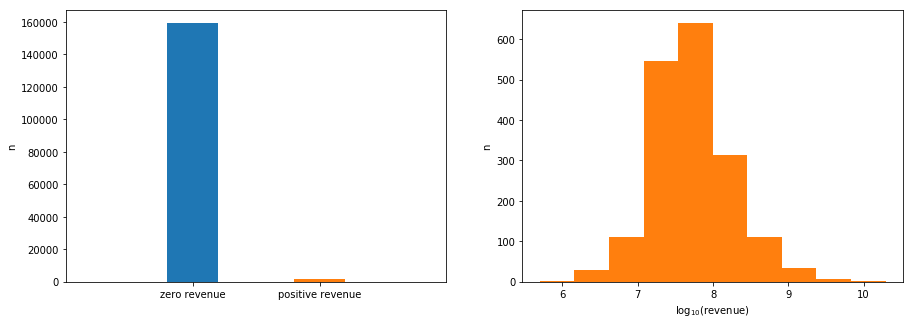

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

ax[0].bar([0,1],
          [len(train_small_target[train_small_target==0]), len(train_small_target[train_small_target!=0])],
          width=0.4, color=['C0','C1'])
ax[0].set_xlim(-1,2)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['zero revenue', 'positive revenue'])
ax[0].set_ylabel('n')

ax[1].hist(np.log10(train_small_target[train_small_target!=0]), color='C1')
ax[1].set_xlabel('log$_{10}$(revenue)')
ax[1].set_ylabel('n')

plt.show(fig)

Add flag that indicates if the visitor has zero or positive revenue:

In [14]:
for i in tqdm_notebook(range(len(train_small))):
    if train_small_target[train_small['fullVisitorId'][i]] == 0:
        train_small.loc[i,'revenue_flag'] = 0
    else:
        train_small.loc[i,'revenue_flag'] = 1

In [15]:
train_small_zero = train_small[train_small['revenue_flag']==0]
train_small_pstv = train_small[train_small['revenue_flag']==1]

### Categorical features

Look at categorical variables:

In [16]:
def zero_vs_pstv_bar(feature):
    """
    Make bar plots that compare zero vs. positive revenue for categorical features.
    
    Parameters
    ----------
    feature : str
        Name of feature.
    """
    unique_vals = train_small[feature].unique()
    n_vals = len(unique_vals)

    val_counts = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts[i] = len(train_small[train_small[feature].isnull()])
        else:
            val_counts[i] = len(train_small[train_small[feature]==unique_vals[i]])

    val_counts_zero = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_zero[i] = len(train_small_zero[train_small_zero[feature].isnull()])
        else:
            val_counts_zero[i] = len(train_small_zero[train_small_zero[feature]==unique_vals[i]])

    val_counts_pstv = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_pstv[i] = len(train_small_pstv[train_small_pstv[feature].isnull()])
        else:
            val_counts_pstv[i] = len(train_small_pstv[train_small_pstv[feature]==unique_vals[i]])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),val_counts,color='C2')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('all')

    ax[1].bar(np.arange(n_vals),val_counts_zero,color='C0')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('zero')

    ax[2].bar(np.arange(n_vals),val_counts_pstv,color='C1')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('positive')

    plt.show(fig)

In [17]:
def zero_vs_pstv_bar_OTHER(feature, unique_vals):
    """
    Make bar plots that compare zero vs. positive revenue for categorical features, including OTHER.
    
    Parameters
    ----------
    feature : str
        Name of feature.
        
    unique_vals : list
        List of categories - must include 'OTHER' as the last item.
    """
    n_vals = len(unique_vals)

    val_counts = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts[i] = len(train_small[train_small[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts[i] = len(train_small[train_small[feature]==unique_vals[i]])
            else:
                val_counts[i] = len(train_small) - np.sum(val_counts)

    val_counts_zero = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_zero[i] = len(train_small_zero[train_small_zero[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_zero[i] = len(train_small_zero[train_small_zero[feature]==unique_vals[i]])
            else:
                val_counts_zero[i] = len(train_small_zero) - np.sum(val_counts_zero)

    val_counts_pstv = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_pstv[i] = len(train_small_pstv[train_small_pstv[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_pstv[i] = len(train_small_pstv[train_small_pstv[feature]==unique_vals[i]])
            else:
                val_counts_pstv[i] = len(train_small_pstv) - np.sum(val_counts_pstv)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),val_counts,color='C2')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('all')

    ax[1].bar(np.arange(n_vals),val_counts_zero,color='C0')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('zero')

    ax[2].bar(np.arange(n_vals),val_counts_pstv,color='C1')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('positive')

    plt.show(fig)

#### channelGrouping

In [18]:
train_small['channelGrouping'].unique()

array(['Organic Search', 'Social', 'Referral', 'Direct', 'Display',
       'Paid Search', 'Affiliates', '(Other)'], dtype=object)

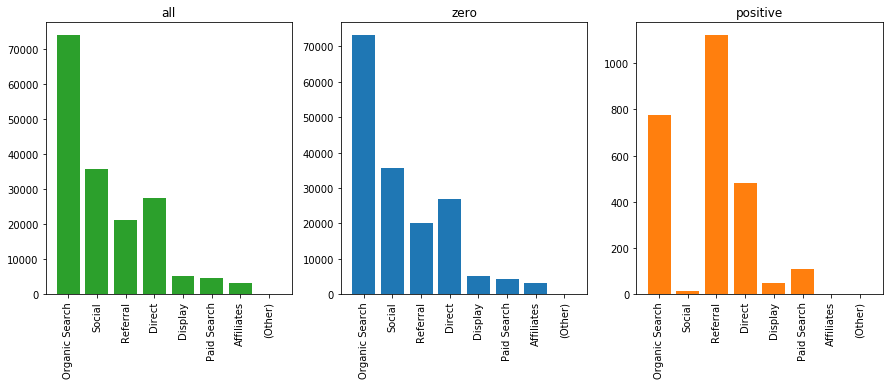

In [19]:
zero_vs_pstv_bar('channelGrouping')

#### device.browser

In [20]:
train_small['device.browser'].unique()

array(['Chrome', 'Safari', 'Samsung Internet', 'Firefox', 'Edge',
       'Safari (in-app)', 'Android Webview', 'UC Browser',
       'Internet Explorer', 'Opera Mini', 'Amazon Silk', 'Opera',
       'Nintendo Browser', 'Iron', 'Android Browser',
       'Mozilla Compatible Agent', 'YaBrowser', 'BlackBerry', 'Coc Coc',
       'SeaMonkey', 'Maxthon', 'MRCHROME', 'Puffin', 'Mozilla', 'DESKTOP',
       'Seznam', 'YE', 'Lunascape', '(not set)',
       ';__CT_JOB_ID__:58e2ecba-7666-4a10-b498-8216457ce472;',
       'Nokia Browser', 'ecwozghsufybtdkjrlvxpamiqn', 'Netscape',
       'wfpknuqxovyilmrdzbhgtecjas', 'LYF_LS_4002_12', 'Nichrome', '0',
       'njroiedbwpmvykqlatxzuhcfgs', 'uhdypcxbgzajmeqwlofnrsitkv',
       '[Use default User-agent string] LIVRENPOCHE',
       'osee2unifiedRelease', 'HTC802t_TD', 'Playstation Vita Browser',
       'ohukwejvqmdtibfrzpycgxanls', 'DASH_JR_3G',
       ';__CT_JOB_ID__:2e0eca60-83ab-482d-bb81-343d113254fb;'],
      dtype=object)

In [21]:
device_browser_value_counts = train_small['device.browser'].value_counts(dropna=False)
device_browser_value_counts[device_browser_value_counts>100]

Chrome               117622
Safari                30963
Firefox                6283
Internet Explorer      3658
Android Webview        3385
Edge                   2043
Samsung Internet       1528
Opera Mini             1511
Safari (in-app)        1398
Opera                   985
UC Browser              564
YaBrowser               278
Amazon Silk             139
Coc Coc                 137
Android Browser         104
Name: device.browser, dtype: int64

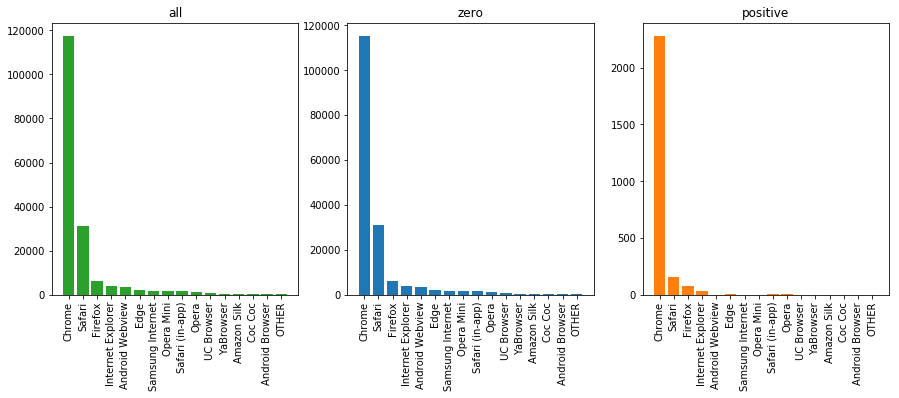

In [22]:
feature = 'device.browser'

unique_vals = device_browser_value_counts[device_browser_value_counts>100].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

#### device.deviceCategory

In [23]:
train_small['device.deviceCategory'].unique()

array(['desktop', 'tablet', 'mobile'], dtype=object)

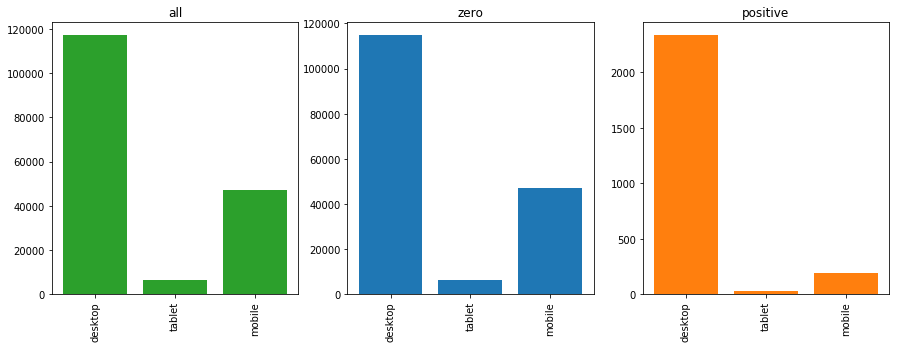

In [24]:
zero_vs_pstv_bar('device.deviceCategory')

#### device.isMobile

In [25]:
train_small['device.isMobile'].unique()

array([False,  True])

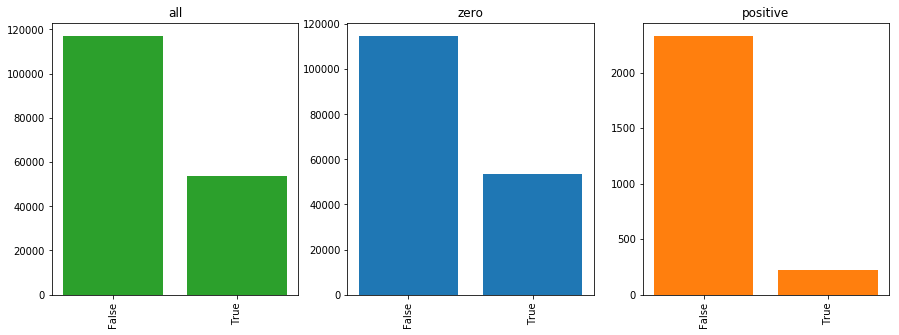

In [26]:
zero_vs_pstv_bar('device.isMobile')

#### device.operatingSystem

In [27]:
train_small['device.operatingSystem'].unique()

array(['Windows', 'Macintosh', 'Linux', 'Chrome OS', 'iOS', 'Android',
       '(not set)', 'BlackBerry', 'Nintendo Wii', 'Xbox', 'Tizen',
       'Samsung', 'Windows Phone', 'Firefox OS', 'OS/2', 'Nintendo WiiU',
       'FreeBSD', 'Nintendo 3DS', 'OpenBSD', 'Playstation Vita',
       'SymbianOS'], dtype=object)

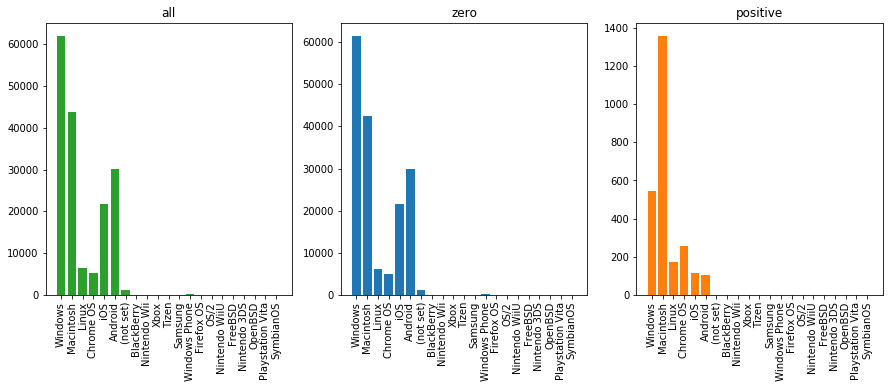

In [28]:
zero_vs_pstv_bar('device.operatingSystem')

#### geoNetwork.continent

In [29]:
train_small['geoNetwork.continent'].unique()

array(['Europe', 'Americas', 'Asia', 'Africa', 'Oceania', '(not set)'],
      dtype=object)

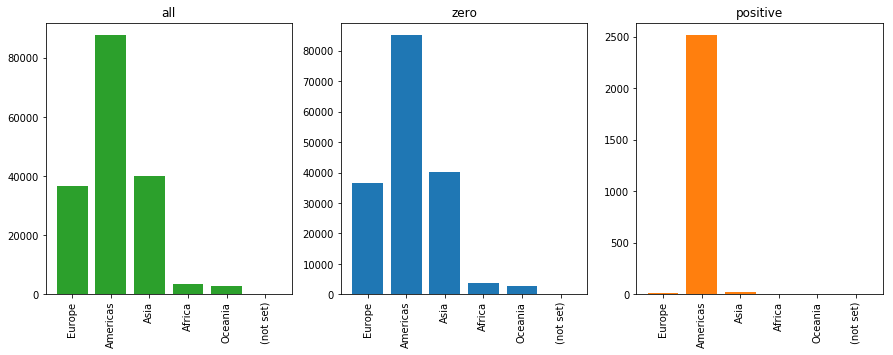

In [30]:
zero_vs_pstv_bar('geoNetwork.continent')

#### geoNetwork.subContinent

In [31]:
train_small['geoNetwork.subContinent'].unique()

array(['Western Europe', 'Eastern Europe', 'Northern America',
       'Southeast Asia', 'Eastern Asia', 'Southern Asia',
       'Central America', 'South America', 'Northern Africa',
       'Australasia', 'Southern Europe', 'Northern Europe',
       'Western Asia', 'Western Africa', 'Southern Africa', 'Caribbean',
       'Central Asia', 'Eastern Africa', '(not set)',
       'Micronesian Region', 'Middle Africa', 'Polynesia', 'Melanesia'],
      dtype=object)

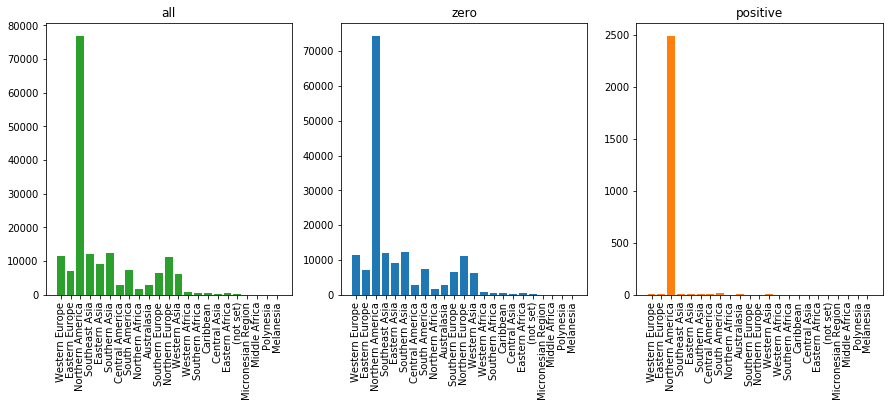

In [32]:
zero_vs_pstv_bar('geoNetwork.subContinent')

#### geoNetwork.networkDomain

In [33]:
train_small['geoNetwork.networkDomain'].unique()

array(['glaslokaal.nl', 't-com.sk', 'rr.com', ..., 'bryanlgh.org',
       'jonkoping.se', 'contabo.net'], dtype=object)

In [34]:
geoNetwork_networkDomain_value_counts = train_small['geoNetwork.networkDomain'].value_counts(dropna=False)
geoNetwork_networkDomain_value_counts[geoNetwork_networkDomain_value_counts>1000]

(not set)              50019
unknown.unknown        26985
comcast.net             5564
rr.com                  2866
verizon.net             2778
ttnet.com.tr            1770
comcastbusiness.net     1738
hinet.net               1652
virginm.net             1253
sbcglobal.net           1074
cox.net                 1033
google.com              1015
Name: geoNetwork.networkDomain, dtype: int64

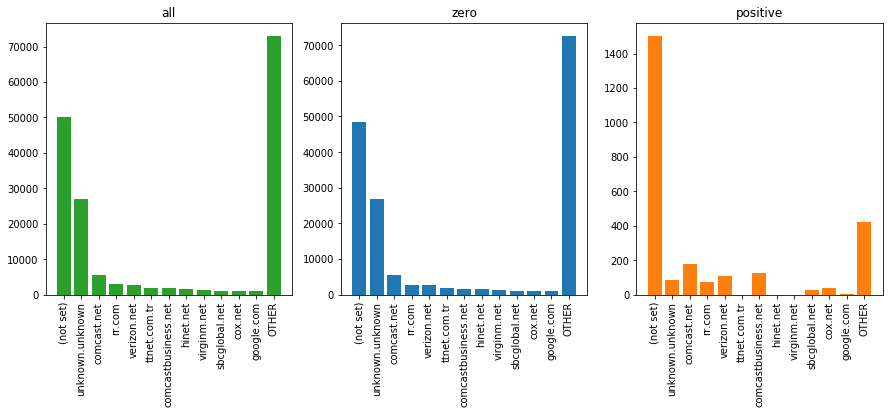

In [35]:
feature = 'geoNetwork.networkDomain'

unique_vals = geoNetwork_networkDomain_value_counts[geoNetwork_networkDomain_value_counts>1000].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

#### trafficSource.adContent

In [36]:
train_small['trafficSource.adContent'].unique()

array([nan, 'Google Merchandise Store', 'Display Ad created 3/11/14',
       'Smart display ad - 8/17/2017', 'Google Merchandise Collection',
       'Official Google Merchandise', 'Placement Accessories 160 x 600',
       'Placement Office 300x250', 'Placement Accessores 300 x 250',
       'Swag with Google Logos', 'Google Online Store',
       'Ad from 12/21/16', 'Placement Accessories 300 x 250',
       'Ad from 12/13/16', 'Display Ad created 3/11/15',
       '{KeyWord:Google Merchandise}', 'Ad from 12/15/17',
       '{KeyWord:Want Google Pet Toys?}',
       '{KeyWord:Looking for Google Bags?}', 'Full auto ad IMAGE ONLY',
       'Placement Drinkware 300x250', '{KeyWord:Want Google Stickers?}',
       'Drinkware 120x600', 'Placement Accessories 336 x 280',
       '{KeyWord:Google Brand Items}', 'Drinkware 336x280',
       'Placement Elecronics 300 x 250', 'BQ', '20% discount',
       'Placement 300 x 250', 'Bags 336x280', 'JD_5a_v1',
       'Ad from 11/3/16', 'Google Store', 'Smart di

In [37]:
trafficSource_adContent_value_counts = train_small['trafficSource.adContent'].value_counts(dropna=False)
trafficSource_adContent_value_counts[trafficSource_adContent_value_counts>100]

NaN                               164383
Google Merchandise Store            3969
Google Merchandise Collection        638
Placement Accessores 300 x 250       288
Smart display ad - 8/17/2017         266
Display Ad created 3/11/14           241
Google Online Store                  181
Name: trafficSource.adContent, dtype: int64

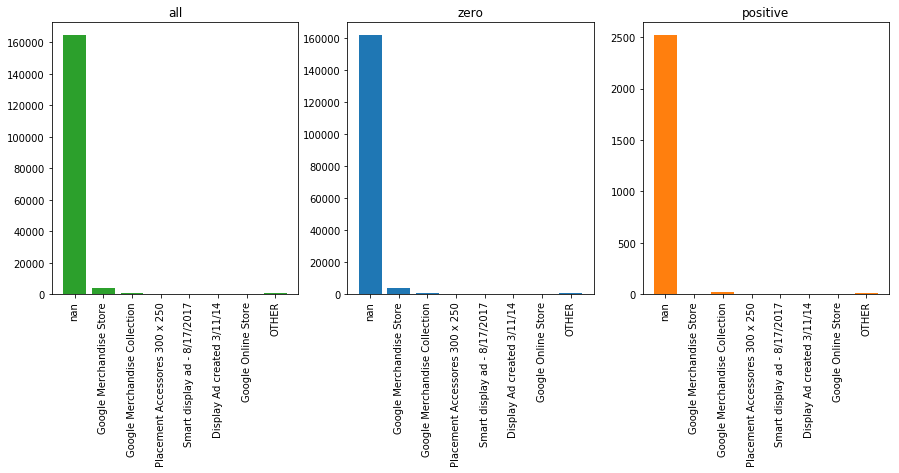

In [38]:
feature = 'trafficSource.adContent'

unique_vals = trafficSource_adContent_value_counts[trafficSource_adContent_value_counts>100].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

#### trafficSource.adwordsClickInfo.adNetworkType

In [39]:
train_small['trafficSource.adwordsClickInfo.adNetworkType'].unique()

array([nan, 'Content', 'Google Search', 'Search partners'], dtype=object)

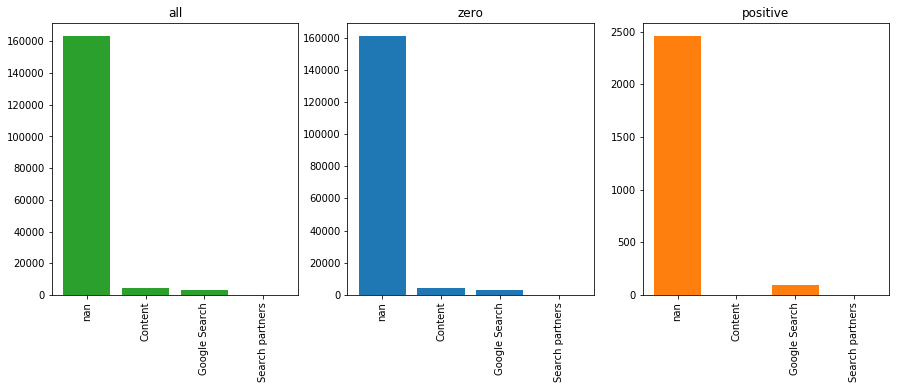

In [40]:
zero_vs_pstv_bar('trafficSource.adwordsClickInfo.adNetworkType')

#### trafficSource.adwordsClickInfo.page

In [41]:
train_small['trafficSource.adwordsClickInfo.page'].unique()

array([nan,  1.,  2.,  4.,  3.,  5.,  7.,  6.])

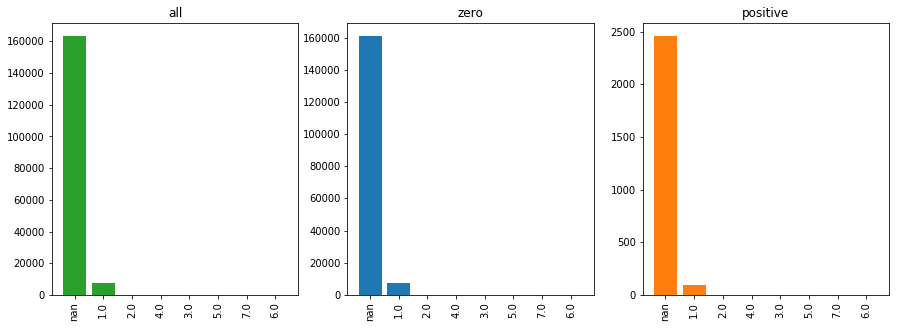

In [42]:
zero_vs_pstv_bar('trafficSource.adwordsClickInfo.page')

#### trafficSource.adwordsClickInfo.slot

In [43]:
train_small['trafficSource.adwordsClickInfo.slot'].unique()

array([nan, 'RHS', 'Top', 'Google Display Network'], dtype=object)

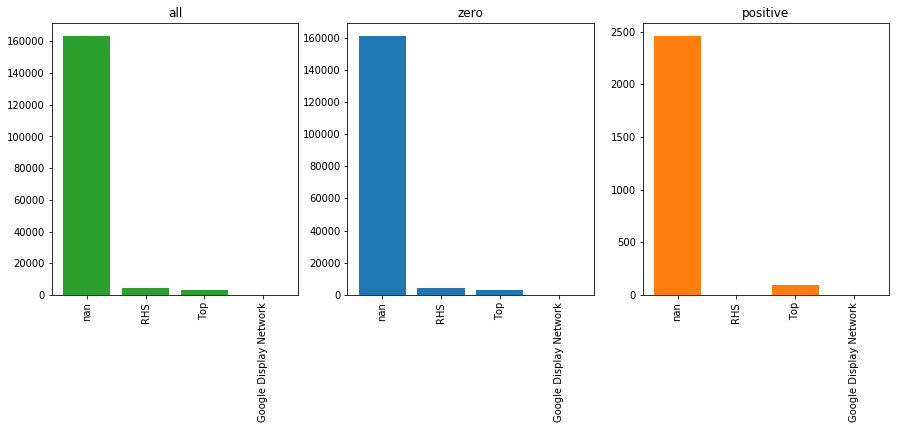

In [44]:
zero_vs_pstv_bar('trafficSource.adwordsClickInfo.slot')

#### trafficSource.adwordsClickInfo.gclId

In [45]:
train_small['trafficSource.adwordsClickInfo.gclId'].unique()

array([nan, 'CIPG_LSputYCFUZgfgodhu4B9Q',
       'Cj0KCQjw09zOBRCqARIsAH8XF1YdoGaqn8NoxWcbV_mHKp-qxeWGWEc_5rMQewb2ToCdhrcDHURtUZ0aAtO9EALw_wcB',
       ...,
       'Cj0KCQjwtJzLBRC7ARIsAGMkOAkN7r-gQcE27Ue1vs4nfZKBXVEXCmDn4zFhofDLfXK885ZCmKFribYaAmSCEALw_wcB',
       'CPTW4KKrzNACFUtufgod_UwLVg', 'CIXyopHdl9ECFUaVfgodf-kBeg'],
      dtype=object)

In [46]:
trafficSource_adwordsClickInfo_gclId_value_counts = train_small['trafficSource.adwordsClickInfo.gclId'].value_counts(dropna=False)
trafficSource_adwordsClickInfo_gclId_value_counts[trafficSource_adwordsClickInfo_gclId_value_counts>3]

NaN                                                                                           163353
CP273vOzr9YCFQEHaQoduBgHSA                                                                         9
CL76p9jTrdYCFRFXDQod9TgCug                                                                         8
COT1-vPT4tYCFZWNswodcwsHxg                                                                         7
CKvL9K7o-tUCFQ52fgodJ6kAzg                                                                         6
CML87ZS65tYCFYUfaAodZrABAQ                                                                         6
CI2Ap4L32tYCFY-1wAodeHEHPA                                                                         5
CKqcobmv6NUCFVQlgQodg4gBdQ                                                                         5
CN3fusbjvtYCFQsmhgodIEQO-g                                                                         5
CN_Whvvc_9UCFd6LswodGTgKCQ                                                                 

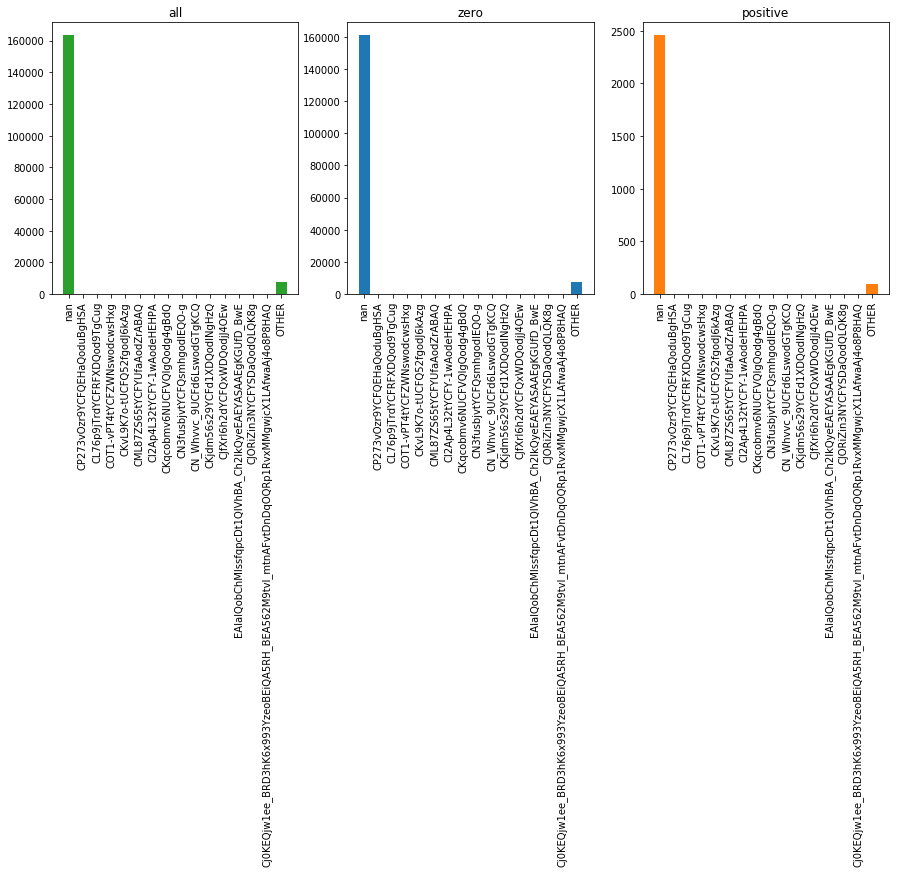

In [47]:
feature = 'trafficSource.adwordsClickInfo.gclId'

unique_vals = trafficSource_adwordsClickInfo_gclId_value_counts[trafficSource_adwordsClickInfo_gclId_value_counts>3].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

#### trafficSource.medium

In [48]:
train_small['trafficSource.medium'].unique()

array(['(none)', 'referral', 'organic', 'cpc', 'cpm', 'affiliate',
       '(not set)'], dtype=object)

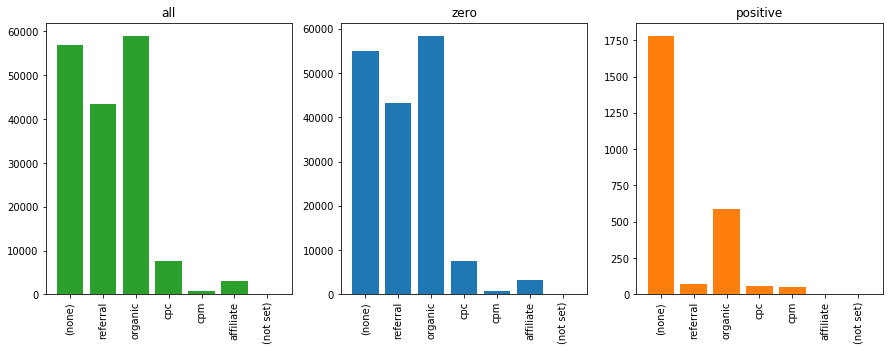

In [49]:
zero_vs_pstv_bar('trafficSource.medium')

#### trafficSource.campaign

In [50]:
train_small['trafficSource.campaign'].unique()

array(['(not set)', '1000557 | GA | US | en | Hybrid | GDN Remarketing',
       'AW - Dynamic Search Ads Whole Site', 'Smart Display Campaign',
       'Data Share Promo', 'AW - Accessories',
       '1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS',
       'Run of Network Line Item',
       'Page: contains "/google+redesign/office"',
       'Media & Entertainment/Music Lovers', 'Technology/Technophiles',
       '"google + redesign/Accessories March 17" All Users Similar Audiences',
       '"google + redesign/Accessories March 17" All Users',
       'Value Shoppers Affinity',
       'Page: contains "/google+redesign/drinkware" Similar Audiences',
       'Sports & Fitness/Health & Fitness Buffs',
       'Media & Entertainment/Movie Lovers',
       'Technology/Mobile Enthusiasts',
       'Page: contains "/google+redesign/office" Similar Audiences',
       'Page: contains "/google+redesign/bags" All Users Similar Audiences',
       'Page: contains "/google+redesign/electronics"',
   

In [51]:
trafficSource_campaign_value_counts = train_small['trafficSource.campaign'].value_counts(dropna=False)
trafficSource_campaign_value_counts[trafficSource_campaign_value_counts>100]

(not set)                                                               160615
Data Share Promo                                                          3168
1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS                    2473
1000557 | GA | US | en | Hybrid | GDN Remarketing                         1495
AW - Dynamic Search Ads Whole Site                                        1477
AW - Accessories                                                           779
Smart Display Campaign                                                     266
"google + redesign/Accessories March 17" All Users Similar Audiences       122
Name: trafficSource.campaign, dtype: int64

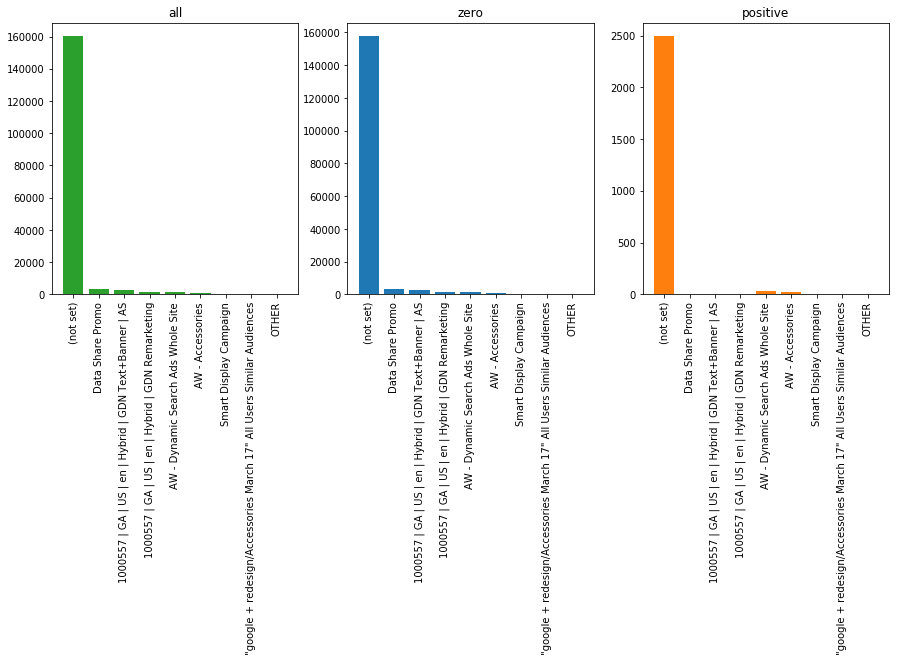

In [52]:
feature = 'trafficSource.campaign'

unique_vals = trafficSource_campaign_value_counts[trafficSource_campaign_value_counts>100].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

#### trafficSource.keyword

In [53]:
trafficSource_keyword_value_counts = train_small['trafficSource.keyword'].value_counts(dropna=False)
trafficSource_keyword_value_counts[trafficSource_keyword_value_counts>100]

NaN                                105424
(not provided)                      56767
(User vertical targeting)            2602
(automatic matching)                 1851
6qEhsCssdK0z36ri                     1036
(Remarketing/Content targeting)       605
1hZbAqLCbjwfgOH7                      318
google merchandise store              255
Google Merchandise                    164
1X4Me6ZKNV0zg-jV                      120
google store                          113
Name: trafficSource.keyword, dtype: int64

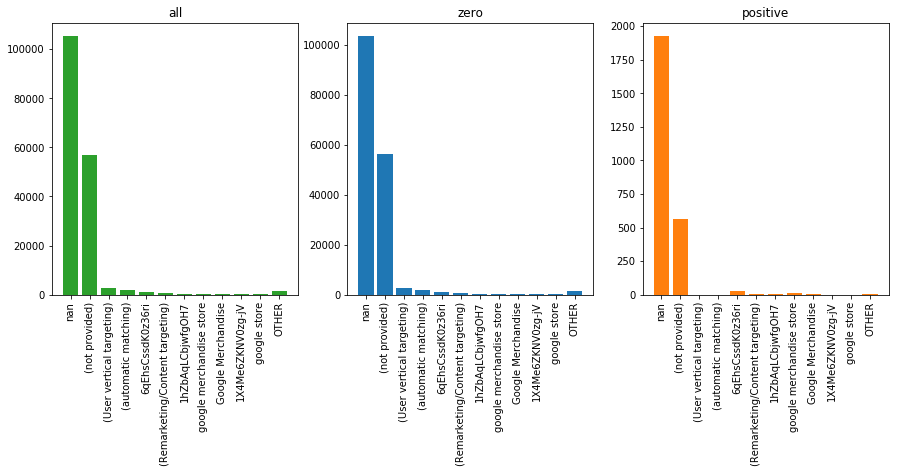

In [54]:
feature = 'trafficSource.keyword'

unique_vals = trafficSource_keyword_value_counts[trafficSource_keyword_value_counts>100].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

#### trafficSource.referralPath

In [55]:
trafficSource_referralPath_value_counts = train_small['trafficSource.referralPath'].value_counts(dropna=False)
trafficSource_referralPath_value_counts[trafficSource_referralPath_value_counts>500]

NaN                                                                                   114119
/                                                                                      13795
/yt/about/                                                                              8088
/analytics/web/                                                                         3306
/yt/about/tr/                                                                           1525
/yt/about/vi/                                                                           1378
/yt/about/es-419/                                                                       1265
/yt/about/pt-BR/                                                                        1185
/yt/about/th/                                                                           1104
/yt/about/ru/                                                                           1102
/offer/2145                                                           

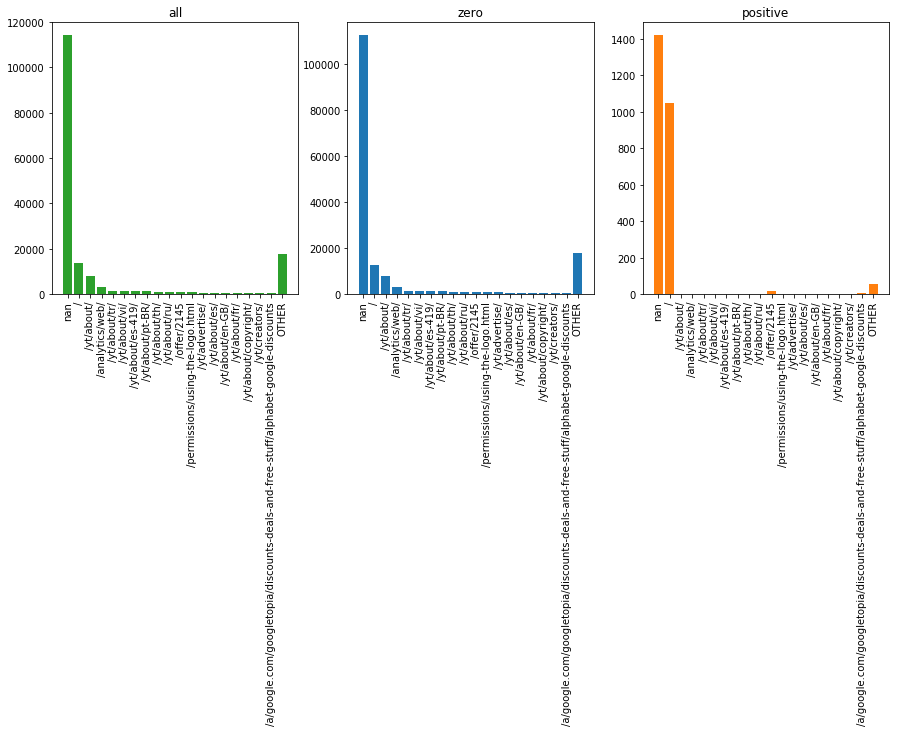

In [56]:
feature = 'trafficSource.referralPath'

unique_vals = trafficSource_referralPath_value_counts[trafficSource_referralPath_value_counts>500].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

#### trafficSource.source

In [57]:
trafficSource_source_value_counts = train_small['trafficSource.source'].value_counts(dropna=False)
trafficSource_source_value_counts[trafficSource_source_value_counts>500]

google                  65671
(direct)                56826
youtube.com             33065
analytics.google.com     3770
Partners                 3169
sites.google.com          877
google.com                809
m.facebook.com            666
dfa                       654
baidu                     502
Name: trafficSource.source, dtype: int64

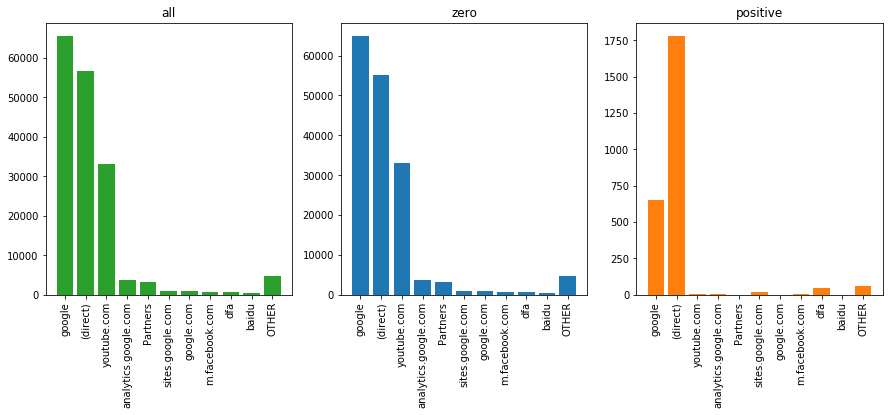

In [58]:
feature = 'trafficSource.source'

unique_vals = trafficSource_source_value_counts[trafficSource_source_value_counts>500].index.to_list()
unique_vals.append('OTHER')

zero_vs_pstv_bar_OTHER(feature, unique_vals)

### Continuous features

In [59]:
train_small_pstv_target = train_small_pstv.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
train_small_pstv_target.sort_index(inplace=True)

#### date

In [60]:
date_value_counts_all = pd.to_datetime(train_small['date'], format='%Y%m%d').value_counts()
date_value_counts_all.sort_index(inplace=True)

date_value_counts_zero = pd.to_datetime(train_small_zero['date'], format='%Y%m%d').value_counts()
date_value_counts_zero.sort_index(inplace=True)

date_value_counts_pstv = pd.to_datetime(train_small_pstv['date'], format='%Y%m%d').value_counts()
date_value_counts_pstv.sort_index(inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


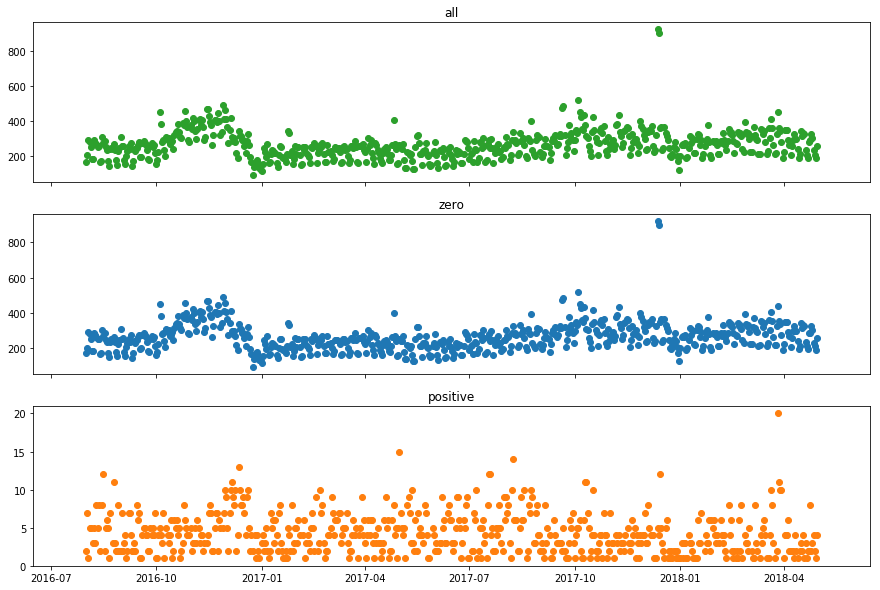

In [61]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10), sharex=True)

ax[0].scatter(date_value_counts_all.index, date_value_counts_all, color='C2')
ax[0].set_title('all')

ax[1].scatter(date_value_counts_zero.index, date_value_counts_zero, color='C0')
ax[1].set_title('zero')

ax[2].scatter(date_value_counts_pstv.index, date_value_counts_pstv, color='C1')
ax[2].set_title('positive')

plt.show(fig)

#### visitStartTime

In [62]:
visitStartTime_value_counts_all = pd.to_datetime(train_small['visitStartTime'], unit='s').value_counts()
visitStartTime_value_counts_all = visitStartTime_value_counts_all.index.hour

visitStartTime_value_counts_zero = pd.to_datetime(train_small_zero['visitStartTime'], unit='s').value_counts()
visitStartTime_value_counts_zero = visitStartTime_value_counts_zero.index.hour

visitStartTime_value_counts_pstv = pd.to_datetime(train_small_pstv['visitStartTime'], unit='s').value_counts()
visitStartTime_value_counts_pstv = visitStartTime_value_counts_pstv.index.hour

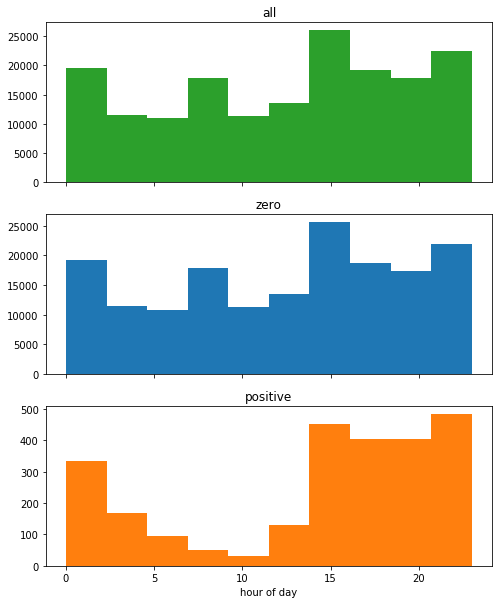

In [63]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(visitStartTime_value_counts_all, color='C2')
ax[0].set_title('all')

ax[1].hist(visitStartTime_value_counts_zero, color='C0')
ax[1].set_title('zero')

ax[2].hist(visitStartTime_value_counts_pstv, color='C1')
ax[2].set_title('positive')

ax[2].set_xlabel('hour of day')

plt.show(fig)

In [64]:
train_small_pstv.loc[:,'visitStartTime_hour'] = pd.to_datetime(train_small_pstv['visitStartTime'], unit='s').dt.hour.values

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


R^2    = nan
p-val. = nan


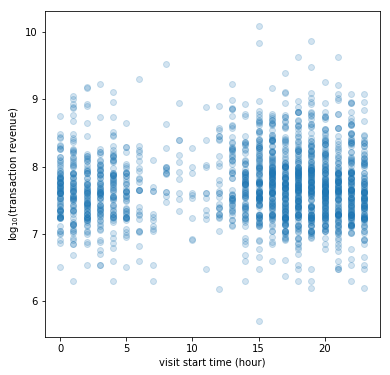

In [65]:
fig, ax = plt.subplots(figsize=(6,6))

x = train_small_pstv['visitStartTime_hour']
y = np.log10(train_small_pstv['totals.transactionRevenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('visit start time (hour)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.hits

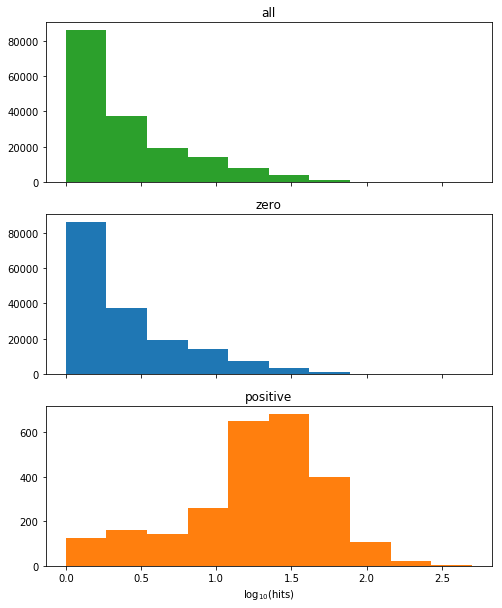

In [66]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_small['totals.hits']), color='C2')
ax[0].set_title('all')

ax[1].hist(np.log10(train_small_zero['totals.hits']), color='C0')
ax[1].set_title('zero')

ax[2].hist(np.log10(train_small_pstv['totals.hits']), color='C1')
ax[2].set_title('positive')

ax[2].set_xlabel('log$_{10}$(hits)')

plt.show(fig)

In [67]:
train_small_pstv_hits = train_small_pstv.groupby('fullVisitorId')['totals.hits'].sum()
train_small_pstv_hits.sort_index(inplace=True)

R^2    = 0.11617271671408289
p-val. = 4.02921687819562e-50


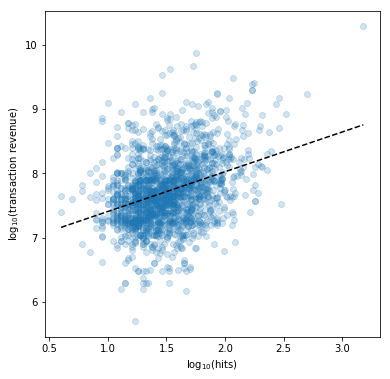

In [68]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_small_pstv_hits)
y = np.log10(train_small_pstv_target)

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(hits)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.pageviews

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


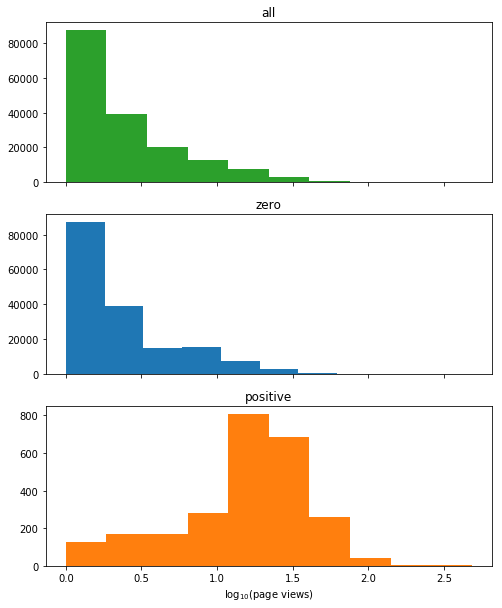

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_small['totals.pageviews']), color='C2')
ax[0].set_title('all')

ax[1].hist(np.log10(train_small_zero['totals.pageviews']), color='C0')
ax[1].set_title('zero')

ax[2].hist(np.log10(train_small_pstv['totals.pageviews']), color='C1')
ax[2].set_title('positive')

ax[2].set_xlabel('log$_{10}$(page views)')

plt.show(fig)

In [70]:
train_small_pstv_pageviews = train_small_pstv.groupby('fullVisitorId')['totals.pageviews'].sum()
train_small_pstv_pageviews.sort_index(inplace=True)

R^2    = 0.09764126517583496
p-val. = 5.3787464330424306e-42


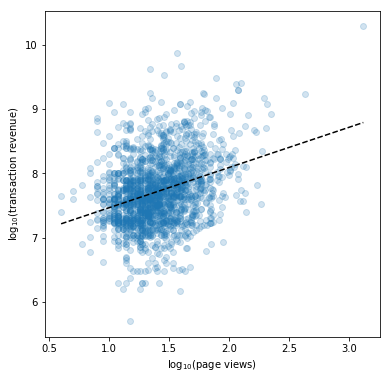

In [71]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_small_pstv_pageviews)
y = np.log10(train_small_pstv_target)

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(page views)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.sessionQualityDim

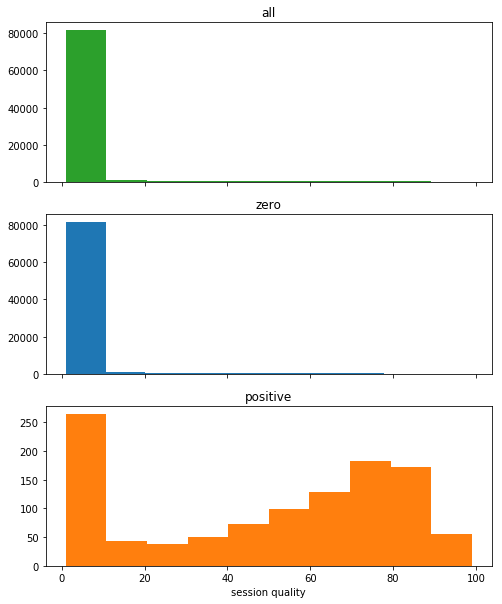

In [72]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(train_small['totals.sessionQualityDim'], color='C2')
ax[0].set_title('all')

ax[1].hist(train_small_zero['totals.sessionQualityDim'], color='C0')
ax[1].set_title('zero')

ax[2].hist(train_small_pstv['totals.sessionQualityDim'], color='C1')
ax[2].set_title('positive')

ax[2].set_xlabel('session quality')

plt.show(fig)

In [73]:
train_small_pstv_sessionQualityDim = train_small_pstv.groupby('fullVisitorId')['totals.sessionQualityDim'].sum()
train_small_pstv_sessionQualityDim.sort_index(inplace=True)

R^2    = 0.0009987264351104896
p-val. = 0.18054766740785344


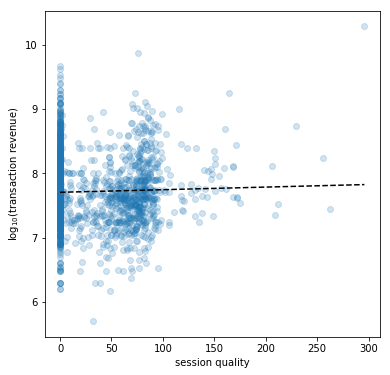

In [74]:
fig, ax = plt.subplots(figsize=(6,6))

x = train_small_pstv_sessionQualityDim
y = np.log10(train_small_pstv_target)

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('session quality')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.timeOnSite

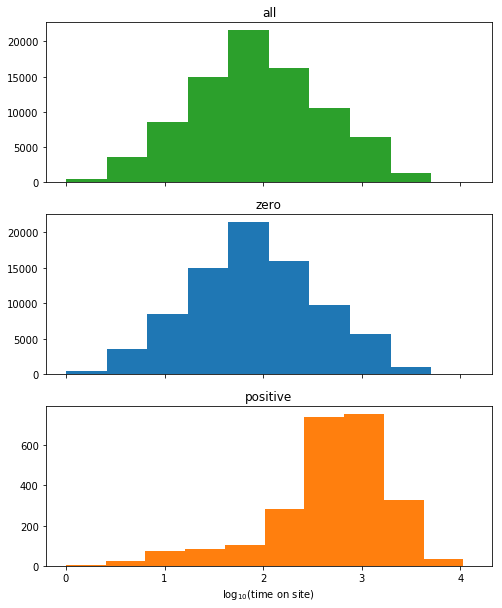

In [75]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_small['totals.timeOnSite']), color='C2')
ax[0].set_title('all')

ax[1].hist(np.log10(train_small_zero['totals.timeOnSite']), color='C0')
ax[1].set_title('zero')

ax[2].hist(np.log10(train_small_pstv['totals.timeOnSite']), color='C1')
ax[2].set_title('positive')

ax[2].set_xlabel('log$_{10}$(time on site)')

plt.show(fig)

In [76]:
train_small_pstv_timeOnSite = train_small_pstv.groupby('fullVisitorId')['totals.timeOnSite'].sum()
train_small_pstv_timeOnSite.sort_index(inplace=True)

R^2    = 0.053154677979341286
p-val. = 4.1525009655878587e-23


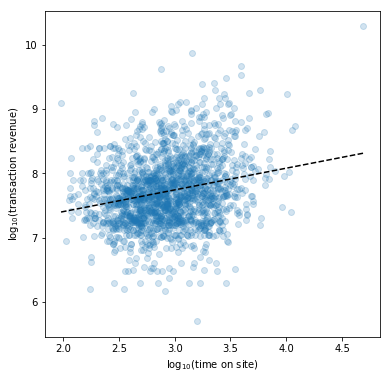

In [77]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_small_pstv_timeOnSite)
y = np.log10(train_small_pstv_target)

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(time on site)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)